<a href="https://colab.research.google.com/github/SourCherries/VAE-GAN-CelebA/blob/master/z_batch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mean Z for every identity in [CelebA](https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html)

## Load modules

In [1]:
!git clone https://github.com/SourCherries/VAE-GAN-CelebA.git

Cloning into 'VAE-GAN-CelebA'...
remote: Enumerating objects: 178, done.
remote: Counting objects: 100% (92/92), done.
remote: Compressing objects: 100% (91/91), done.
remote: Total 178 (delta 41), reused 0 (delta 0), pack-reused 86
Receiving objects: 100% (178/178), 4.44 MiB | 4.79 MiB/s, done.
Resolving deltas: 100% (79/79), done.


In [2]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [3]:
import sys, getopt
if sys.version_info < (3,4):
    print('You are running an older version of Python!\n\n',
          'You should consider updating to Python 3.4.0 or',
          'higher.\n')
print(sys.version)

sys.path.insert(0,'/content/VAE-GAN-CelebA/libs')
sys.path.insert(0,'/content/VAE-GAN-CelebA/')

import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import libs.make_network as make_network
import libs.utils as utils
from scipy.io import loadmat, savemat
import imageio
from skimage.util import montage
import pandas as pd
import seaborn as sns

print('TF version = ',tf.__version__)

3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]
TF version =  1.15.2


In [4]:
# Download Tensorflow checkpoint
! gdown --id 1o9nUhtZEX9GZXsTmvCXSNjEjDQ7Q1wHV

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1o9nUhtZEX9GZXsTmvCXSNjEjDQ7Q1wHV
To: /content/vaegan_celeba.ckpt
100% 555M/555M [00:11<00:00, 50.3MB/s]


## Load images

In [5]:
# Two faces
# https://drive.google.com/file/d/1SLm933s8UgqZqU76dacDIhpPAqRb-FH-/view?usp=sharing
! gdown --id 1SLm933s8UgqZqU76dacDIhpPAqRb-FH-

# CelebA
# https://drive.google.com/file/d/172v_Sfx-MyE2nS59jxl6W9-so3Xvyhkj/view?usp=sharing
! gdown --id 172v_Sfx-MyE2nS59jxl6W9-so3Xvyhkj

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1SLm933s8UgqZqU76dacDIhpPAqRb-FH-
To: /content/twofaces.zip
100% 188k/188k [00:00<00:00, 113MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=172v_Sfx-MyE2nS59jxl6W9-so3Xvyhkj
To: /content/img_align_celeba.zip
100% 1.44G/1.44G [00:26<00:00, 54.1MB/s]


## Access images from zip

In [6]:
import zipfile
import io
from PIL import Image
from torchvision import transforms

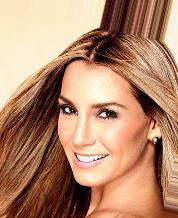

img_align_celeba/000001.jpg


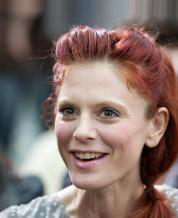

img_align_celeba/000002.jpg
2 images processed.


In [7]:
z = zipfile.ZipFile("img_align_celeba.zip")
counter = 0
imgs = np.zeros((2, 128, 128, 3))
# for i in range(len(z.namelist())):
for i in range(3):

    file_in_zip = z.namelist()[i]
    if (".jpg" in file_in_zip or ".JPG" in file_in_zip):
        counter += 1
        data = z.read(file_in_zip)
        dataEnc = io.BytesIO(data)
        img = Image.open(dataEnc)
        display(img) #  Jupyter specific function
        print(file_in_zip)
        img = utils.preprocess128(np.array(img),crop_factor=0.8)[np.newaxis]
        imgs[counter-1, :, :, :] = img
print(f'{counter} images processed.')

## Model

In [7]:
sess, X, G, Z, Z_mu, is_training, saver = make_network.make_network()

if os.path.exists("vaegan_celeba.ckpt"):
    saver.restore(sess, "vaegan_celeba.ckpt")
    print("VAE-GAN model restored.")
else:
    print("Pre-trained network appears to be missing.")
    sys.exit()




encoder/input: [None, 128, 128, 3]

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

layer: 0 , shape: [None, 64, 64, 192]
layer: 1 , shape: [None, 32, 32, 256]
layer: 2 , shape: [None, 16, 16, 384]
layer: 3 , shape: [None, 8, 8, 512]
layer: 4 , shape: [None, 4, 4, 768]


Instructions for updating:
Use `tf.global_variables_initializer` instead.

Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Restoring parameters from vaegan_celeba.ckpt
VAE-GAN model restored.


## Batchwise convert to z

In [9]:
z = sess.run(Z_mu, feed_dict={X: imgs, is_training: False})
z.shape

(2, 1024)

## Batchwise convert to images

In [8]:
def imdeprocess(g):
    stretch = 1.0
    for i in range(g.shape[0]):
        g[i]=np.clip(stretch*g[i] / (g.max()),0,1)
    return g

In [11]:
g = sess.run(G, feed_dict={Z: (1*z), is_training: False})

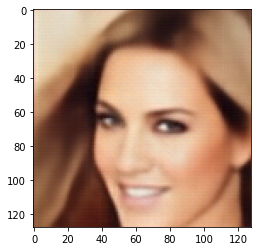

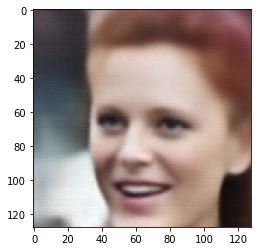

In [12]:
for gg in g:
  img = imdeprocess(gg)
  plt.imshow(img); plt.show()

Everything works. Lets run in batches.

# Actual batch processing

In [14]:
import pandas as pd
from tqdm import tqdm

In [15]:
labels = pd.read_csv("/content/VAE-GAN-CelebA/identity_CelebA.txt", header=None, sep="\s+", names=["file","id"])
zippyzocker = zipfile.ZipFile("img_align_celeba.zip")

In [17]:
n = len(labels)
batch_size = 16
epochs = n // batch_size

SumZ = dict()
NumZ = dict()
for ei in tqdm(range(epochs)):
  lindex = range(ei * batch_size, (ei+1) * batch_size)
  # lin = [loc for loc in lindex]
  # print(lin[0], lin[-1])

  # Get/format batch of images
  imgs = np.zeros((batch_size, 128, 128, 3))
  batch_labels = []
  for counter, loc in enumerate(lindex):
    # img_align_celeba/000001.jpg
    file_name = labels["file"][loc]
    file_in_zip = "img_align_celeba/" + file_name
    data = zippyzocker.read(file_in_zip)
    dataEnc = io.BytesIO(data)
    img = Image.open(dataEnc)
    img = utils.preprocess128(np.array(img),crop_factor=0.8)[np.newaxis]
    imgs[counter, :, :, :] = img
    batch_labels.append(labels["id"][loc])
  
  # Encode to Z, (batch_size, 1024)
  z = sess.run(Z_mu, feed_dict={X: imgs, is_training: False})

  # Loop ID of each z-vector in batch,
  #   initializing key/value in dict if key does not exist,
  #   else add to value of existing key.
  for counter, this_id in enumerate(batch_labels):
    # this_id = labels["id"][0]
    if this_id in list(SumZ):
      SumZ[this_id] += z[counter, :]
      NumZ[this_id] += 1
    else:
      SumZ[this_id] = z[counter, :]
      NumZ[this_id] = 1

  0%|          | 1/12662 [00:00<26:30,  7.96it/s]

img_align_celeba/000001.jpg
img_align_celeba/000002.jpg
img_align_celeba/000003.jpg
img_align_celeba/000004.jpg
img_align_celeba/000005.jpg
img_align_celeba/000006.jpg
img_align_celeba/000007.jpg
img_align_celeba/000008.jpg
img_align_celeba/000009.jpg
img_align_celeba/000010.jpg
img_align_celeba/000011.jpg
img_align_celeba/000012.jpg
img_align_celeba/000013.jpg
img_align_celeba/000014.jpg
img_align_celeba/000015.jpg
img_align_celeba/000016.jpg
img_align_celeba/000017.jpg
img_align_celeba/000018.jpg
img_align_celeba/000019.jpg
img_align_celeba/000020.jpg
img_align_celeba/000021.jpg
img_align_celeba/000022.jpg
img_align_celeba/000023.jpg
img_align_celeba/000024.jpg
img_align_celeba/000025.jpg
img_align_celeba/000026.jpg
img_align_celeba/000027.jpg
img_align_celeba/000028.jpg
img_align_celeba/000029.jpg


  0%|          | 3/12662 [00:00<26:55,  7.84it/s]

img_align_celeba/000030.jpg
img_align_celeba/000031.jpg
img_align_celeba/000032.jpg
img_align_celeba/000033.jpg
img_align_celeba/000034.jpg
img_align_celeba/000035.jpg
img_align_celeba/000036.jpg
img_align_celeba/000037.jpg
img_align_celeba/000038.jpg
img_align_celeba/000039.jpg
img_align_celeba/000040.jpg
img_align_celeba/000041.jpg
img_align_celeba/000042.jpg
img_align_celeba/000043.jpg
img_align_celeba/000044.jpg
img_align_celeba/000045.jpg
img_align_celeba/000046.jpg
img_align_celeba/000047.jpg
img_align_celeba/000048.jpg
img_align_celeba/000049.jpg
img_align_celeba/000050.jpg
img_align_celeba/000051.jpg
img_align_celeba/000052.jpg


  0%|          | 4/12662 [00:00<29:34,  7.13it/s]

img_align_celeba/000053.jpg
img_align_celeba/000054.jpg
img_align_celeba/000055.jpg
img_align_celeba/000056.jpg
img_align_celeba/000057.jpg
img_align_celeba/000058.jpg
img_align_celeba/000059.jpg
img_align_celeba/000060.jpg
img_align_celeba/000061.jpg
img_align_celeba/000062.jpg
img_align_celeba/000063.jpg
img_align_celeba/000064.jpg
img_align_celeba/000065.jpg
img_align_celeba/000066.jpg
img_align_celeba/000067.jpg
img_align_celeba/000068.jpg
img_align_celeba/000069.jpg
img_align_celeba/000070.jpg
img_align_celeba/000071.jpg
img_align_celeba/000072.jpg
img_align_celeba/000073.jpg
img_align_celeba/000074.jpg
img_align_celeba/000075.jpg
img_align_celeba/000076.jpg
img_align_celeba/000077.jpg


  0%|          | 6/12662 [00:00<28:32,  7.39it/s]

img_align_celeba/000078.jpg
img_align_celeba/000079.jpg
img_align_celeba/000080.jpg
img_align_celeba/000081.jpg
img_align_celeba/000082.jpg
img_align_celeba/000083.jpg
img_align_celeba/000084.jpg
img_align_celeba/000085.jpg
img_align_celeba/000086.jpg
img_align_celeba/000087.jpg
img_align_celeba/000088.jpg
img_align_celeba/000089.jpg
img_align_celeba/000090.jpg
img_align_celeba/000091.jpg
img_align_celeba/000092.jpg
img_align_celeba/000093.jpg
img_align_celeba/000094.jpg
img_align_celeba/000095.jpg
img_align_celeba/000096.jpg
img_align_celeba/000097.jpg
img_align_celeba/000098.jpg
img_align_celeba/000099.jpg
img_align_celeba/000100.jpg


  0%|          | 7/12662 [00:00<28:32,  7.39it/s]

img_align_celeba/000101.jpg
img_align_celeba/000102.jpg
img_align_celeba/000103.jpg
img_align_celeba/000104.jpg
img_align_celeba/000105.jpg
img_align_celeba/000106.jpg
img_align_celeba/000107.jpg
img_align_celeba/000108.jpg
img_align_celeba/000109.jpg
img_align_celeba/000110.jpg
img_align_celeba/000111.jpg
img_align_celeba/000112.jpg
img_align_celeba/000113.jpg
img_align_celeba/000114.jpg
img_align_celeba/000115.jpg
img_align_celeba/000116.jpg
img_align_celeba/000117.jpg
img_align_celeba/000118.jpg
img_align_celeba/000119.jpg
img_align_celeba/000120.jpg
img_align_celeba/000121.jpg
img_align_celeba/000122.jpg
img_align_celeba/000123.jpg
img_align_celeba/000124.jpg
img_align_celeba/000125.jpg
img_align_celeba/000126.jpg
img_align_celeba/000127.jpg


  0%|          | 9/12662 [00:01<28:47,  7.33it/s]

img_align_celeba/000128.jpg
img_align_celeba/000129.jpg
img_align_celeba/000130.jpg
img_align_celeba/000131.jpg
img_align_celeba/000132.jpg
img_align_celeba/000133.jpg
img_align_celeba/000134.jpg
img_align_celeba/000135.jpg
img_align_celeba/000136.jpg
img_align_celeba/000137.jpg
img_align_celeba/000138.jpg
img_align_celeba/000139.jpg
img_align_celeba/000140.jpg
img_align_celeba/000141.jpg
img_align_celeba/000142.jpg
img_align_celeba/000143.jpg
img_align_celeba/000144.jpg
img_align_celeba/000145.jpg
img_align_celeba/000146.jpg
img_align_celeba/000147.jpg
img_align_celeba/000148.jpg
img_align_celeba/000149.jpg


  0%|          | 10/12662 [00:01<28:22,  7.43it/s]

img_align_celeba/000150.jpg
img_align_celeba/000151.jpg
img_align_celeba/000152.jpg
img_align_celeba/000153.jpg
img_align_celeba/000154.jpg
img_align_celeba/000155.jpg
img_align_celeba/000156.jpg
img_align_celeba/000157.jpg
img_align_celeba/000158.jpg
img_align_celeba/000159.jpg
img_align_celeba/000160.jpg
img_align_celeba/000161.jpg
img_align_celeba/000162.jpg
img_align_celeba/000163.jpg
img_align_celeba/000164.jpg
img_align_celeba/000165.jpg
img_align_celeba/000166.jpg
img_align_celeba/000167.jpg
img_align_celeba/000168.jpg
img_align_celeba/000169.jpg
img_align_celeba/000170.jpg
img_align_celeba/000171.jpg
img_align_celeba/000172.jpg
img_align_celeba/000173.jpg
img_align_celeba/000174.jpg
img_align_celeba/000175.jpg
img_align_celeba/000176.jpg


  0%|          | 12/12662 [00:01<27:38,  7.63it/s]

img_align_celeba/000177.jpg
img_align_celeba/000178.jpg
img_align_celeba/000179.jpg
img_align_celeba/000180.jpg
img_align_celeba/000181.jpg
img_align_celeba/000182.jpg
img_align_celeba/000183.jpg
img_align_celeba/000184.jpg
img_align_celeba/000185.jpg
img_align_celeba/000186.jpg
img_align_celeba/000187.jpg
img_align_celeba/000188.jpg
img_align_celeba/000189.jpg
img_align_celeba/000190.jpg
img_align_celeba/000191.jpg
img_align_celeba/000192.jpg
img_align_celeba/000193.jpg
img_align_celeba/000194.jpg
img_align_celeba/000195.jpg
img_align_celeba/000196.jpg
img_align_celeba/000197.jpg
img_align_celeba/000198.jpg
img_align_celeba/000199.jpg
img_align_celeba/000200.jpg
img_align_celeba/000201.jpg
img_align_celeba/000202.jpg
img_align_celeba/000203.jpg
img_align_celeba/000204.jpg


  0%|          | 14/12662 [00:01<26:55,  7.83it/s]

img_align_celeba/000205.jpg
img_align_celeba/000206.jpg
img_align_celeba/000207.jpg
img_align_celeba/000208.jpg
img_align_celeba/000209.jpg
img_align_celeba/000210.jpg
img_align_celeba/000211.jpg
img_align_celeba/000212.jpg
img_align_celeba/000213.jpg
img_align_celeba/000214.jpg
img_align_celeba/000215.jpg
img_align_celeba/000216.jpg
img_align_celeba/000217.jpg
img_align_celeba/000218.jpg
img_align_celeba/000219.jpg
img_align_celeba/000220.jpg
img_align_celeba/000221.jpg
img_align_celeba/000222.jpg
img_align_celeba/000223.jpg
img_align_celeba/000224.jpg
img_align_celeba/000225.jpg
img_align_celeba/000226.jpg
img_align_celeba/000227.jpg
img_align_celeba/000228.jpg


  0%|          | 15/12662 [00:01<27:40,  7.62it/s]

img_align_celeba/000229.jpg
img_align_celeba/000230.jpg
img_align_celeba/000231.jpg
img_align_celeba/000232.jpg
img_align_celeba/000233.jpg
img_align_celeba/000234.jpg
img_align_celeba/000235.jpg
img_align_celeba/000236.jpg
img_align_celeba/000237.jpg
img_align_celeba/000238.jpg
img_align_celeba/000239.jpg
img_align_celeba/000240.jpg
img_align_celeba/000241.jpg
img_align_celeba/000242.jpg
img_align_celeba/000243.jpg
img_align_celeba/000244.jpg
img_align_celeba/000245.jpg
img_align_celeba/000246.jpg
img_align_celeba/000247.jpg
img_align_celeba/000248.jpg
img_align_celeba/000249.jpg
img_align_celeba/000250.jpg
img_align_celeba/000251.jpg
img_align_celeba/000252.jpg
img_align_celeba/000253.jpg
img_align_celeba/000254.jpg
img_align_celeba/000255.jpg


  0%|          | 17/12662 [00:02<27:17,  7.72it/s]

img_align_celeba/000256.jpg
img_align_celeba/000257.jpg
img_align_celeba/000258.jpg
img_align_celeba/000259.jpg
img_align_celeba/000260.jpg
img_align_celeba/000261.jpg
img_align_celeba/000262.jpg
img_align_celeba/000263.jpg
img_align_celeba/000264.jpg
img_align_celeba/000265.jpg
img_align_celeba/000266.jpg
img_align_celeba/000267.jpg
img_align_celeba/000268.jpg
img_align_celeba/000269.jpg
img_align_celeba/000270.jpg
img_align_celeba/000271.jpg
img_align_celeba/000272.jpg
img_align_celeba/000273.jpg
img_align_celeba/000274.jpg
img_align_celeba/000275.jpg
img_align_celeba/000276.jpg
img_align_celeba/000277.jpg
img_align_celeba/000278.jpg
img_align_celeba/000279.jpg


  0%|          | 19/12662 [00:02<26:47,  7.86it/s]

img_align_celeba/000280.jpg
img_align_celeba/000281.jpg
img_align_celeba/000282.jpg
img_align_celeba/000283.jpg
img_align_celeba/000284.jpg
img_align_celeba/000285.jpg
img_align_celeba/000286.jpg
img_align_celeba/000287.jpg
img_align_celeba/000288.jpg
img_align_celeba/000289.jpg
img_align_celeba/000290.jpg
img_align_celeba/000291.jpg
img_align_celeba/000292.jpg
img_align_celeba/000293.jpg
img_align_celeba/000294.jpg
img_align_celeba/000295.jpg
img_align_celeba/000296.jpg
img_align_celeba/000297.jpg
img_align_celeba/000298.jpg
img_align_celeba/000299.jpg
img_align_celeba/000300.jpg
img_align_celeba/000301.jpg
img_align_celeba/000302.jpg
img_align_celeba/000303.jpg
img_align_celeba/000304.jpg
img_align_celeba/000305.jpg


  0%|          | 20/12662 [00:02<27:21,  7.70it/s]

img_align_celeba/000306.jpg
img_align_celeba/000307.jpg
img_align_celeba/000308.jpg
img_align_celeba/000309.jpg
img_align_celeba/000310.jpg
img_align_celeba/000311.jpg
img_align_celeba/000312.jpg
img_align_celeba/000313.jpg
img_align_celeba/000314.jpg
img_align_celeba/000315.jpg
img_align_celeba/000316.jpg
img_align_celeba/000317.jpg
img_align_celeba/000318.jpg
img_align_celeba/000319.jpg
img_align_celeba/000320.jpg
img_align_celeba/000321.jpg
img_align_celeba/000322.jpg
img_align_celeba/000323.jpg
img_align_celeba/000324.jpg
img_align_celeba/000325.jpg
img_align_celeba/000326.jpg
img_align_celeba/000327.jpg
img_align_celeba/000328.jpg
img_align_celeba/000329.jpg
img_align_celeba/000330.jpg
img_align_celeba/000331.jpg
img_align_celeba/000332.jpg
img_align_celeba/000333.jpg


  0%|          | 22/12662 [00:02<26:33,  7.93it/s]

img_align_celeba/000334.jpg
img_align_celeba/000335.jpg
img_align_celeba/000336.jpg
img_align_celeba/000337.jpg
img_align_celeba/000338.jpg
img_align_celeba/000339.jpg
img_align_celeba/000340.jpg
img_align_celeba/000341.jpg
img_align_celeba/000342.jpg
img_align_celeba/000343.jpg
img_align_celeba/000344.jpg
img_align_celeba/000345.jpg
img_align_celeba/000346.jpg
img_align_celeba/000347.jpg
img_align_celeba/000348.jpg
img_align_celeba/000349.jpg
img_align_celeba/000350.jpg
img_align_celeba/000351.jpg
img_align_celeba/000352.jpg
img_align_celeba/000353.jpg
img_align_celeba/000354.jpg
img_align_celeba/000355.jpg
img_align_celeba/000356.jpg
img_align_celeba/000357.jpg
img_align_celeba/000358.jpg


  0%|          | 23/12662 [00:03<26:20,  8.00it/s]

img_align_celeba/000359.jpg
img_align_celeba/000360.jpg
img_align_celeba/000361.jpg
img_align_celeba/000362.jpg
img_align_celeba/000363.jpg
img_align_celeba/000364.jpg
img_align_celeba/000365.jpg
img_align_celeba/000366.jpg
img_align_celeba/000367.jpg
img_align_celeba/000368.jpg
img_align_celeba/000369.jpg
img_align_celeba/000370.jpg
img_align_celeba/000371.jpg
img_align_celeba/000372.jpg
img_align_celeba/000373.jpg
img_align_celeba/000374.jpg
img_align_celeba/000375.jpg
img_align_celeba/000376.jpg
img_align_celeba/000377.jpg
img_align_celeba/000378.jpg
img_align_celeba/000379.jpg
img_align_celeba/000380.jpg
img_align_celeba/000381.jpg
img_align_celeba/000382.jpg
img_align_celeba/000383.jpg
img_align_celeba/000384.jpg


  0%|          | 25/12662 [00:03<26:42,  7.89it/s]

img_align_celeba/000385.jpg
img_align_celeba/000386.jpg
img_align_celeba/000387.jpg
img_align_celeba/000388.jpg
img_align_celeba/000389.jpg
img_align_celeba/000390.jpg
img_align_celeba/000391.jpg
img_align_celeba/000392.jpg
img_align_celeba/000393.jpg
img_align_celeba/000394.jpg
img_align_celeba/000395.jpg
img_align_celeba/000396.jpg
img_align_celeba/000397.jpg
img_align_celeba/000398.jpg
img_align_celeba/000399.jpg
img_align_celeba/000400.jpg
img_align_celeba/000401.jpg
img_align_celeba/000402.jpg
img_align_celeba/000403.jpg
img_align_celeba/000404.jpg
img_align_celeba/000405.jpg
img_align_celeba/000406.jpg
img_align_celeba/000407.jpg
img_align_celeba/000408.jpg
img_align_celeba/000409.jpg
img_align_celeba/000410.jpg
img_align_celeba/000411.jpg
img_align_celeba/000412.jpg


  0%|          | 27/12662 [00:03<27:49,  7.57it/s]

img_align_celeba/000413.jpg
img_align_celeba/000414.jpg
img_align_celeba/000415.jpg
img_align_celeba/000416.jpg
img_align_celeba/000417.jpg
img_align_celeba/000418.jpg
img_align_celeba/000419.jpg
img_align_celeba/000420.jpg
img_align_celeba/000421.jpg
img_align_celeba/000422.jpg
img_align_celeba/000423.jpg
img_align_celeba/000424.jpg
img_align_celeba/000425.jpg
img_align_celeba/000426.jpg
img_align_celeba/000427.jpg
img_align_celeba/000428.jpg
img_align_celeba/000429.jpg
img_align_celeba/000430.jpg
img_align_celeba/000431.jpg
img_align_celeba/000432.jpg
img_align_celeba/000433.jpg
img_align_celeba/000434.jpg


  0%|          | 28/12662 [00:03<28:07,  7.49it/s]

img_align_celeba/000435.jpg
img_align_celeba/000436.jpg
img_align_celeba/000437.jpg
img_align_celeba/000438.jpg
img_align_celeba/000439.jpg
img_align_celeba/000440.jpg
img_align_celeba/000441.jpg
img_align_celeba/000442.jpg
img_align_celeba/000443.jpg
img_align_celeba/000444.jpg
img_align_celeba/000445.jpg
img_align_celeba/000446.jpg
img_align_celeba/000447.jpg
img_align_celeba/000448.jpg
img_align_celeba/000449.jpg
img_align_celeba/000450.jpg
img_align_celeba/000451.jpg
img_align_celeba/000452.jpg
img_align_celeba/000453.jpg
img_align_celeba/000454.jpg
img_align_celeba/000455.jpg
img_align_celeba/000456.jpg
img_align_celeba/000457.jpg
img_align_celeba/000458.jpg
img_align_celeba/000459.jpg
img_align_celeba/000460.jpg
img_align_celeba/000461.jpg


  0%|          | 30/12662 [00:03<28:00,  7.52it/s]

img_align_celeba/000462.jpg
img_align_celeba/000463.jpg
img_align_celeba/000464.jpg
img_align_celeba/000465.jpg
img_align_celeba/000466.jpg
img_align_celeba/000467.jpg
img_align_celeba/000468.jpg
img_align_celeba/000469.jpg
img_align_celeba/000470.jpg
img_align_celeba/000471.jpg
img_align_celeba/000472.jpg
img_align_celeba/000473.jpg
img_align_celeba/000474.jpg
img_align_celeba/000475.jpg
img_align_celeba/000476.jpg
img_align_celeba/000477.jpg
img_align_celeba/000478.jpg
img_align_celeba/000479.jpg
img_align_celeba/000480.jpg
img_align_celeba/000481.jpg
img_align_celeba/000482.jpg
img_align_celeba/000483.jpg


  0%|          | 31/12662 [00:04<28:01,  7.51it/s]

img_align_celeba/000484.jpg
img_align_celeba/000485.jpg
img_align_celeba/000486.jpg
img_align_celeba/000487.jpg
img_align_celeba/000488.jpg
img_align_celeba/000489.jpg
img_align_celeba/000490.jpg
img_align_celeba/000491.jpg
img_align_celeba/000492.jpg
img_align_celeba/000493.jpg
img_align_celeba/000494.jpg
img_align_celeba/000495.jpg
img_align_celeba/000496.jpg
img_align_celeba/000497.jpg
img_align_celeba/000498.jpg
img_align_celeba/000499.jpg
img_align_celeba/000500.jpg
img_align_celeba/000501.jpg
img_align_celeba/000502.jpg
img_align_celeba/000503.jpg
img_align_celeba/000504.jpg
img_align_celeba/000505.jpg
img_align_celeba/000506.jpg
img_align_celeba/000507.jpg
img_align_celeba/000508.jpg
img_align_celeba/000509.jpg
img_align_celeba/000510.jpg
img_align_celeba/000511.jpg

  0%|          | 33/12662 [00:04<27:38,  7.61it/s]


img_align_celeba/000512.jpg
img_align_celeba/000513.jpg
img_align_celeba/000514.jpg
img_align_celeba/000515.jpg
img_align_celeba/000516.jpg
img_align_celeba/000517.jpg
img_align_celeba/000518.jpg
img_align_celeba/000519.jpg
img_align_celeba/000520.jpg
img_align_celeba/000521.jpg
img_align_celeba/000522.jpg
img_align_celeba/000523.jpg
img_align_celeba/000524.jpg
img_align_celeba/000525.jpg
img_align_celeba/000526.jpg
img_align_celeba/000527.jpg
img_align_celeba/000528.jpg
img_align_celeba/000529.jpg
img_align_celeba/000530.jpg
img_align_celeba/000531.jpg
img_align_celeba/000532.jpg
img_align_celeba/000533.jpg
img_align_celeba/000534.jpg


  0%|          | 34/12662 [00:04<27:15,  7.72it/s]

img_align_celeba/000535.jpg
img_align_celeba/000536.jpg
img_align_celeba/000537.jpg
img_align_celeba/000538.jpg
img_align_celeba/000539.jpg
img_align_celeba/000540.jpg
img_align_celeba/000541.jpg
img_align_celeba/000542.jpg
img_align_celeba/000543.jpg
img_align_celeba/000544.jpg
img_align_celeba/000545.jpg
img_align_celeba/000546.jpg
img_align_celeba/000547.jpg
img_align_celeba/000548.jpg
img_align_celeba/000549.jpg
img_align_celeba/000550.jpg
img_align_celeba/000551.jpg
img_align_celeba/000552.jpg
img_align_celeba/000553.jpg
img_align_celeba/000554.jpg
img_align_celeba/000555.jpg
img_align_celeba/000556.jpg
img_align_celeba/000557.jpg
img_align_celeba/000558.jpg
img_align_celeba/000559.jpg
img_align_celeba/000560.jpg


  0%|          | 36/12662 [00:04<26:44,  7.87it/s]

img_align_celeba/000561.jpg
img_align_celeba/000562.jpg
img_align_celeba/000563.jpg
img_align_celeba/000564.jpg
img_align_celeba/000565.jpg
img_align_celeba/000566.jpg
img_align_celeba/000567.jpg
img_align_celeba/000568.jpg
img_align_celeba/000569.jpg
img_align_celeba/000570.jpg
img_align_celeba/000571.jpg
img_align_celeba/000572.jpg
img_align_celeba/000573.jpg
img_align_celeba/000574.jpg
img_align_celeba/000575.jpg
img_align_celeba/000576.jpg
img_align_celeba/000577.jpg
img_align_celeba/000578.jpg
img_align_celeba/000579.jpg
img_align_celeba/000580.jpg
img_align_celeba/000581.jpg
img_align_celeba/000582.jpg
img_align_celeba/000583.jpg
img_align_celeba/000584.jpg
img_align_celeba/000585.jpg
img_align_celeba/000586.jpg
img_align_celeba/000587.jpg
img_align_celeba/000588.jpg
img_align_celeba/000589.jpg
img_align_celeba/000590.jpg


  0%|          | 38/12662 [00:04<26:02,  8.08it/s]

img_align_celeba/000591.jpg
img_align_celeba/000592.jpg
img_align_celeba/000593.jpg
img_align_celeba/000594.jpg
img_align_celeba/000595.jpg
img_align_celeba/000596.jpg
img_align_celeba/000597.jpg
img_align_celeba/000598.jpg
img_align_celeba/000599.jpg
img_align_celeba/000600.jpg
img_align_celeba/000601.jpg
img_align_celeba/000602.jpg
img_align_celeba/000603.jpg
img_align_celeba/000604.jpg
img_align_celeba/000605.jpg
img_align_celeba/000606.jpg
img_align_celeba/000607.jpg
img_align_celeba/000608.jpg
img_align_celeba/000609.jpg
img_align_celeba/000610.jpg
img_align_celeba/000611.jpg
img_align_celeba/000612.jpg
img_align_celeba/000613.jpg
img_align_celeba/000614.jpg
img_align_celeba/000615.jpg
img_align_celeba/000616.jpg
img_align_celeba/000617.jpg


  0%|          | 40/12662 [00:05<25:57,  8.10it/s]

img_align_celeba/000618.jpg
img_align_celeba/000619.jpg
img_align_celeba/000620.jpg
img_align_celeba/000621.jpg
img_align_celeba/000622.jpg
img_align_celeba/000623.jpg
img_align_celeba/000624.jpg
img_align_celeba/000625.jpg
img_align_celeba/000626.jpg
img_align_celeba/000627.jpg
img_align_celeba/000628.jpg
img_align_celeba/000629.jpg
img_align_celeba/000630.jpg
img_align_celeba/000631.jpg
img_align_celeba/000632.jpg
img_align_celeba/000633.jpg
img_align_celeba/000634.jpg
img_align_celeba/000635.jpg
img_align_celeba/000636.jpg
img_align_celeba/000637.jpg
img_align_celeba/000638.jpg
img_align_celeba/000639.jpg
img_align_celeba/000640.jpg
img_align_celeba/000641.jpg
img_align_celeba/000642.jpg


  0%|          | 41/12662 [00:05<26:17,  8.00it/s]

img_align_celeba/000643.jpg
img_align_celeba/000644.jpg
img_align_celeba/000645.jpg
img_align_celeba/000646.jpg
img_align_celeba/000647.jpg
img_align_celeba/000648.jpg
img_align_celeba/000649.jpg
img_align_celeba/000650.jpg
img_align_celeba/000651.jpg
img_align_celeba/000652.jpg
img_align_celeba/000653.jpg
img_align_celeba/000654.jpg
img_align_celeba/000655.jpg
img_align_celeba/000656.jpg
img_align_celeba/000657.jpg
img_align_celeba/000658.jpg
img_align_celeba/000659.jpg
img_align_celeba/000660.jpg
img_align_celeba/000661.jpg
img_align_celeba/000662.jpg
img_align_celeba/000663.jpg
img_align_celeba/000664.jpg
img_align_celeba/000665.jpg
img_align_celeba/000666.jpg
img_align_celeba/000667.jpg
img_align_celeba/000668.jpg
img_align_celeba/000669.jpg
img_align_celeba/000670.jpg


  0%|          | 43/12662 [00:05<27:20,  7.69it/s]

img_align_celeba/000671.jpg
img_align_celeba/000672.jpg
img_align_celeba/000673.jpg
img_align_celeba/000674.jpg
img_align_celeba/000675.jpg
img_align_celeba/000676.jpg
img_align_celeba/000677.jpg
img_align_celeba/000678.jpg
img_align_celeba/000679.jpg
img_align_celeba/000680.jpg
img_align_celeba/000681.jpg
img_align_celeba/000682.jpg
img_align_celeba/000683.jpg
img_align_celeba/000684.jpg
img_align_celeba/000685.jpg
img_align_celeba/000686.jpg
img_align_celeba/000687.jpg
img_align_celeba/000688.jpg
img_align_celeba/000689.jpg
img_align_celeba/000690.jpg
img_align_celeba/000691.jpg


  0%|          | 44/12662 [00:05<28:09,  7.47it/s]

img_align_celeba/000692.jpg
img_align_celeba/000693.jpg
img_align_celeba/000694.jpg
img_align_celeba/000695.jpg
img_align_celeba/000696.jpg
img_align_celeba/000697.jpg
img_align_celeba/000698.jpg
img_align_celeba/000699.jpg
img_align_celeba/000700.jpg
img_align_celeba/000701.jpg
img_align_celeba/000702.jpg
img_align_celeba/000703.jpg
img_align_celeba/000704.jpg
img_align_celeba/000705.jpg
img_align_celeba/000706.jpg
img_align_celeba/000707.jpg
img_align_celeba/000708.jpg
img_align_celeba/000709.jpg
img_align_celeba/000710.jpg
img_align_celeba/000711.jpg
img_align_celeba/000712.jpg
img_align_celeba/000713.jpg
img_align_celeba/000714.jpg
img_align_celeba/000715.jpg
img_align_celeba/000716.jpg
img_align_celeba/000717.jpg
img_align_celeba/000718.jpg


  0%|          | 46/12662 [00:05<28:13,  7.45it/s]

img_align_celeba/000719.jpg
img_align_celeba/000720.jpg
img_align_celeba/000721.jpg
img_align_celeba/000722.jpg
img_align_celeba/000723.jpg
img_align_celeba/000724.jpg
img_align_celeba/000725.jpg
img_align_celeba/000726.jpg
img_align_celeba/000727.jpg
img_align_celeba/000728.jpg
img_align_celeba/000729.jpg
img_align_celeba/000730.jpg
img_align_celeba/000731.jpg
img_align_celeba/000732.jpg
img_align_celeba/000733.jpg
img_align_celeba/000734.jpg
img_align_celeba/000735.jpg
img_align_celeba/000736.jpg
img_align_celeba/000737.jpg
img_align_celeba/000738.jpg
img_align_celeba/000739.jpg
img_align_celeba/000740.jpg
img_align_celeba/000741.jpg


  0%|          | 47/12662 [00:06<28:27,  7.39it/s]

img_align_celeba/000742.jpg
img_align_celeba/000743.jpg
img_align_celeba/000744.jpg
img_align_celeba/000745.jpg
img_align_celeba/000746.jpg
img_align_celeba/000747.jpg
img_align_celeba/000748.jpg
img_align_celeba/000749.jpg
img_align_celeba/000750.jpg
img_align_celeba/000751.jpg
img_align_celeba/000752.jpg
img_align_celeba/000753.jpg
img_align_celeba/000754.jpg
img_align_celeba/000755.jpg
img_align_celeba/000756.jpg
img_align_celeba/000757.jpg
img_align_celeba/000758.jpg
img_align_celeba/000759.jpg
img_align_celeba/000760.jpg
img_align_celeba/000761.jpg
img_align_celeba/000762.jpg
img_align_celeba/000763.jpg
img_align_celeba/000764.jpg
img_align_celeba/000765.jpg
img_align_celeba/000766.jpg
img_align_celeba/000767.jpg
img_align_celeba/000768.jpg


  0%|          | 49/12662 [00:06<26:45,  7.86it/s]

img_align_celeba/000769.jpg
img_align_celeba/000770.jpg
img_align_celeba/000771.jpg
img_align_celeba/000772.jpg
img_align_celeba/000773.jpg
img_align_celeba/000774.jpg
img_align_celeba/000775.jpg
img_align_celeba/000776.jpg
img_align_celeba/000777.jpg
img_align_celeba/000778.jpg
img_align_celeba/000779.jpg
img_align_celeba/000780.jpg
img_align_celeba/000781.jpg
img_align_celeba/000782.jpg
img_align_celeba/000783.jpg
img_align_celeba/000784.jpg
img_align_celeba/000785.jpg
img_align_celeba/000786.jpg
img_align_celeba/000787.jpg
img_align_celeba/000788.jpg
img_align_celeba/000789.jpg
img_align_celeba/000790.jpg
img_align_celeba/000791.jpg
img_align_celeba/000792.jpg
img_align_celeba/000793.jpg
img_align_celeba/000794.jpg
img_align_celeba/000795.jpg
img_align_celeba/000796.jpg
img_align_celeba/000797.jpg
img_align_celeba/000798.jpg
img_align_celeba/000799.jpg


  0%|          | 51/12662 [00:06<26:23,  7.97it/s]

img_align_celeba/000800.jpg
img_align_celeba/000801.jpg
img_align_celeba/000802.jpg
img_align_celeba/000803.jpg
img_align_celeba/000804.jpg
img_align_celeba/000805.jpg
img_align_celeba/000806.jpg
img_align_celeba/000807.jpg
img_align_celeba/000808.jpg
img_align_celeba/000809.jpg
img_align_celeba/000810.jpg
img_align_celeba/000811.jpg
img_align_celeba/000812.jpg
img_align_celeba/000813.jpg
img_align_celeba/000814.jpg
img_align_celeba/000815.jpg
img_align_celeba/000816.jpg
img_align_celeba/000817.jpg
img_align_celeba/000818.jpg
img_align_celeba/000819.jpg
img_align_celeba/000820.jpg
img_align_celeba/000821.jpg
img_align_celeba/000822.jpg
img_align_celeba/000823.jpg
img_align_celeba/000824.jpg


  0%|          | 53/12662 [00:06<26:02,  8.07it/s]

img_align_celeba/000825.jpg
img_align_celeba/000826.jpg
img_align_celeba/000827.jpg
img_align_celeba/000828.jpg
img_align_celeba/000829.jpg
img_align_celeba/000830.jpg
img_align_celeba/000831.jpg
img_align_celeba/000832.jpg
img_align_celeba/000833.jpg
img_align_celeba/000834.jpg
img_align_celeba/000835.jpg
img_align_celeba/000836.jpg
img_align_celeba/000837.jpg
img_align_celeba/000838.jpg
img_align_celeba/000839.jpg
img_align_celeba/000840.jpg
img_align_celeba/000841.jpg
img_align_celeba/000842.jpg
img_align_celeba/000843.jpg
img_align_celeba/000844.jpg
img_align_celeba/000845.jpg
img_align_celeba/000846.jpg
img_align_celeba/000847.jpg
img_align_celeba/000848.jpg
img_align_celeba/000849.jpg


  0%|          | 54/12662 [00:07<26:27,  7.94it/s]

img_align_celeba/000850.jpg
img_align_celeba/000851.jpg
img_align_celeba/000852.jpg
img_align_celeba/000853.jpg
img_align_celeba/000854.jpg
img_align_celeba/000855.jpg
img_align_celeba/000856.jpg
img_align_celeba/000857.jpg
img_align_celeba/000858.jpg
img_align_celeba/000859.jpg
img_align_celeba/000860.jpg
img_align_celeba/000861.jpg
img_align_celeba/000862.jpg
img_align_celeba/000863.jpg
img_align_celeba/000864.jpg
img_align_celeba/000865.jpg
img_align_celeba/000866.jpg
img_align_celeba/000867.jpg
img_align_celeba/000868.jpg
img_align_celeba/000869.jpg
img_align_celeba/000870.jpg
img_align_celeba/000871.jpg
img_align_celeba/000872.jpg
img_align_celeba/000873.jpg
img_align_celeba/000874.jpg
img_align_celeba/000875.jpg
img_align_celeba/000876.jpg
img_align_celeba/000877.jpg
img_align_celeba/000878.jpg

  0%|          | 56/12662 [00:07<27:02,  7.77it/s]


img_align_celeba/000879.jpg
img_align_celeba/000880.jpg
img_align_celeba/000881.jpg
img_align_celeba/000882.jpg
img_align_celeba/000883.jpg
img_align_celeba/000884.jpg
img_align_celeba/000885.jpg
img_align_celeba/000886.jpg
img_align_celeba/000887.jpg
img_align_celeba/000888.jpg
img_align_celeba/000889.jpg
img_align_celeba/000890.jpg
img_align_celeba/000891.jpg
img_align_celeba/000892.jpg
img_align_celeba/000893.jpg
img_align_celeba/000894.jpg
img_align_celeba/000895.jpg
img_align_celeba/000896.jpg
img_align_celeba/000897.jpg
img_align_celeba/000898.jpg
img_align_celeba/000899.jpg
img_align_celeba/000900.jpg


  0%|          | 57/12662 [00:07<26:56,  7.80it/s]

img_align_celeba/000901.jpg
img_align_celeba/000902.jpg
img_align_celeba/000903.jpg
img_align_celeba/000904.jpg
img_align_celeba/000905.jpg
img_align_celeba/000906.jpg
img_align_celeba/000907.jpg
img_align_celeba/000908.jpg
img_align_celeba/000909.jpg
img_align_celeba/000910.jpg
img_align_celeba/000911.jpg
img_align_celeba/000912.jpg
img_align_celeba/000913.jpg
img_align_celeba/000914.jpg
img_align_celeba/000915.jpg
img_align_celeba/000916.jpg
img_align_celeba/000917.jpg
img_align_celeba/000918.jpg
img_align_celeba/000919.jpg
img_align_celeba/000920.jpg
img_align_celeba/000921.jpg
img_align_celeba/000922.jpg
img_align_celeba/000923.jpg
img_align_celeba/000924.jpg
img_align_celeba/000925.jpg
img_align_celeba/000926.jpg
img_align_celeba/000927.jpg
img_align_celeba/000928.jpg


  0%|          | 59/12662 [00:07<26:41,  7.87it/s]

img_align_celeba/000929.jpg
img_align_celeba/000930.jpg
img_align_celeba/000931.jpg
img_align_celeba/000932.jpg
img_align_celeba/000933.jpg
img_align_celeba/000934.jpg
img_align_celeba/000935.jpg
img_align_celeba/000936.jpg
img_align_celeba/000937.jpg
img_align_celeba/000938.jpg
img_align_celeba/000939.jpg
img_align_celeba/000940.jpg
img_align_celeba/000941.jpg
img_align_celeba/000942.jpg
img_align_celeba/000943.jpg
img_align_celeba/000944.jpg
img_align_celeba/000945.jpg
img_align_celeba/000946.jpg
img_align_celeba/000947.jpg
img_align_celeba/000948.jpg
img_align_celeba/000949.jpg
img_align_celeba/000950.jpg
img_align_celeba/000951.jpg
img_align_celeba/000952.jpg
img_align_celeba/000953.jpg
img_align_celeba/000954.jpg
img_align_celeba/000955.jpg


  0%|          | 61/12662 [00:07<27:11,  7.72it/s]

img_align_celeba/000956.jpg
img_align_celeba/000957.jpg
img_align_celeba/000958.jpg
img_align_celeba/000959.jpg
img_align_celeba/000960.jpg
img_align_celeba/000961.jpg
img_align_celeba/000962.jpg
img_align_celeba/000963.jpg
img_align_celeba/000964.jpg
img_align_celeba/000965.jpg
img_align_celeba/000966.jpg
img_align_celeba/000967.jpg
img_align_celeba/000968.jpg
img_align_celeba/000969.jpg
img_align_celeba/000970.jpg
img_align_celeba/000971.jpg
img_align_celeba/000972.jpg
img_align_celeba/000973.jpg
img_align_celeba/000974.jpg
img_align_celeba/000975.jpg
img_align_celeba/000976.jpg
img_align_celeba/000977.jpg
img_align_celeba/000978.jpg
img_align_celeba/000979.jpg


  0%|          | 62/12662 [00:08<27:24,  7.66it/s]

img_align_celeba/000980.jpg
img_align_celeba/000981.jpg
img_align_celeba/000982.jpg
img_align_celeba/000983.jpg
img_align_celeba/000984.jpg
img_align_celeba/000985.jpg
img_align_celeba/000986.jpg
img_align_celeba/000987.jpg
img_align_celeba/000988.jpg
img_align_celeba/000989.jpg
img_align_celeba/000990.jpg
img_align_celeba/000991.jpg
img_align_celeba/000992.jpg
img_align_celeba/000993.jpg
img_align_celeba/000994.jpg
img_align_celeba/000995.jpg
img_align_celeba/000996.jpg
img_align_celeba/000997.jpg
img_align_celeba/000998.jpg
img_align_celeba/000999.jpg
img_align_celeba/001000.jpg
img_align_celeba/001001.jpg
img_align_celeba/001002.jpg
img_align_celeba/001003.jpg
img_align_celeba/001004.jpg
img_align_celeba/001005.jpg
img_align_celeba/001006.jpg
img_align_celeba/001007.jpg


  1%|          | 64/12662 [00:08<27:21,  7.68it/s]

img_align_celeba/001008.jpg
img_align_celeba/001009.jpg
img_align_celeba/001010.jpg
img_align_celeba/001011.jpg
img_align_celeba/001012.jpg
img_align_celeba/001013.jpg
img_align_celeba/001014.jpg
img_align_celeba/001015.jpg
img_align_celeba/001016.jpg
img_align_celeba/001017.jpg
img_align_celeba/001018.jpg
img_align_celeba/001019.jpg
img_align_celeba/001020.jpg
img_align_celeba/001021.jpg
img_align_celeba/001022.jpg
img_align_celeba/001023.jpg
img_align_celeba/001024.jpg
img_align_celeba/001025.jpg
img_align_celeba/001026.jpg
img_align_celeba/001027.jpg
img_align_celeba/001028.jpg
img_align_celeba/001029.jpg
img_align_celeba/001030.jpg
img_align_celeba/001031.jpg

  1%|          | 65/12662 [00:08<27:19,  7.68it/s]


img_align_celeba/001032.jpg
img_align_celeba/001033.jpg
img_align_celeba/001034.jpg
img_align_celeba/001035.jpg
img_align_celeba/001036.jpg
img_align_celeba/001037.jpg
img_align_celeba/001038.jpg
img_align_celeba/001039.jpg
img_align_celeba/001040.jpg
img_align_celeba/001041.jpg
img_align_celeba/001042.jpg
img_align_celeba/001043.jpg
img_align_celeba/001044.jpg
img_align_celeba/001045.jpg
img_align_celeba/001046.jpg
img_align_celeba/001047.jpg
img_align_celeba/001048.jpg
img_align_celeba/001049.jpg
img_align_celeba/001050.jpg
img_align_celeba/001051.jpg
img_align_celeba/001052.jpg
img_align_celeba/001053.jpg
img_align_celeba/001054.jpg
img_align_celeba/001055.jpg
img_align_celeba/001056.jpg


  1%|          | 67/12662 [00:08<27:27,  7.64it/s]

img_align_celeba/001057.jpg
img_align_celeba/001058.jpg
img_align_celeba/001059.jpg
img_align_celeba/001060.jpg
img_align_celeba/001061.jpg
img_align_celeba/001062.jpg
img_align_celeba/001063.jpg
img_align_celeba/001064.jpg
img_align_celeba/001065.jpg
img_align_celeba/001066.jpg
img_align_celeba/001067.jpg
img_align_celeba/001068.jpg
img_align_celeba/001069.jpg
img_align_celeba/001070.jpg
img_align_celeba/001071.jpg
img_align_celeba/001072.jpg
img_align_celeba/001073.jpg
img_align_celeba/001074.jpg
img_align_celeba/001075.jpg
img_align_celeba/001076.jpg
img_align_celeba/001077.jpg
img_align_celeba/001078.jpg
img_align_celeba/001079.jpg
img_align_celeba/001080.jpg
img_align_celeba/001081.jpg
img_align_celeba/001082.jpg
img_align_celeba/001083.jpg


  1%|          | 69/12662 [00:08<27:13,  7.71it/s]

img_align_celeba/001084.jpg
img_align_celeba/001085.jpg
img_align_celeba/001086.jpg
img_align_celeba/001087.jpg
img_align_celeba/001088.jpg
img_align_celeba/001089.jpg
img_align_celeba/001090.jpg
img_align_celeba/001091.jpg
img_align_celeba/001092.jpg
img_align_celeba/001093.jpg
img_align_celeba/001094.jpg
img_align_celeba/001095.jpg
img_align_celeba/001096.jpg
img_align_celeba/001097.jpg
img_align_celeba/001098.jpg
img_align_celeba/001099.jpg
img_align_celeba/001100.jpg
img_align_celeba/001101.jpg
img_align_celeba/001102.jpg
img_align_celeba/001103.jpg
img_align_celeba/001104.jpg
img_align_celeba/001105.jpg
img_align_celeba/001106.jpg
img_align_celeba/001107.jpg


  1%|          | 70/12662 [00:09<27:12,  7.71it/s]

img_align_celeba/001108.jpg
img_align_celeba/001109.jpg
img_align_celeba/001110.jpg
img_align_celeba/001111.jpg
img_align_celeba/001112.jpg
img_align_celeba/001113.jpg
img_align_celeba/001114.jpg
img_align_celeba/001115.jpg
img_align_celeba/001116.jpg
img_align_celeba/001117.jpg
img_align_celeba/001118.jpg
img_align_celeba/001119.jpg
img_align_celeba/001120.jpg
img_align_celeba/001121.jpg
img_align_celeba/001122.jpg
img_align_celeba/001123.jpg
img_align_celeba/001124.jpg
img_align_celeba/001125.jpg
img_align_celeba/001126.jpg
img_align_celeba/001127.jpg
img_align_celeba/001128.jpg
img_align_celeba/001129.jpg
img_align_celeba/001130.jpg
img_align_celeba/001131.jpg
img_align_celeba/001132.jpg
img_align_celeba/001133.jpg
img_align_celeba/001134.jpg


  1%|          | 72/12662 [00:09<27:21,  7.67it/s]

img_align_celeba/001135.jpg
img_align_celeba/001136.jpg
img_align_celeba/001137.jpg
img_align_celeba/001138.jpg
img_align_celeba/001139.jpg
img_align_celeba/001140.jpg
img_align_celeba/001141.jpg
img_align_celeba/001142.jpg
img_align_celeba/001143.jpg
img_align_celeba/001144.jpg
img_align_celeba/001145.jpg
img_align_celeba/001146.jpg
img_align_celeba/001147.jpg
img_align_celeba/001148.jpg
img_align_celeba/001149.jpg
img_align_celeba/001150.jpg
img_align_celeba/001151.jpg
img_align_celeba/001152.jpg
img_align_celeba/001153.jpg
img_align_celeba/001154.jpg
img_align_celeba/001155.jpg
img_align_celeba/001156.jpg
img_align_celeba/001157.jpg


  1%|          | 73/12662 [00:09<27:32,  7.62it/s]

img_align_celeba/001158.jpg
img_align_celeba/001159.jpg
img_align_celeba/001160.jpg
img_align_celeba/001161.jpg
img_align_celeba/001162.jpg
img_align_celeba/001163.jpg
img_align_celeba/001164.jpg
img_align_celeba/001165.jpg
img_align_celeba/001166.jpg
img_align_celeba/001167.jpg
img_align_celeba/001168.jpg
img_align_celeba/001169.jpg
img_align_celeba/001170.jpg
img_align_celeba/001171.jpg
img_align_celeba/001172.jpg
img_align_celeba/001173.jpg
img_align_celeba/001174.jpg
img_align_celeba/001175.jpg
img_align_celeba/001176.jpg
img_align_celeba/001177.jpg
img_align_celeba/001178.jpg
img_align_celeba/001179.jpg
img_align_celeba/001180.jpg
img_align_celeba/001181.jpg
img_align_celeba/001182.jpg
img_align_celeba/001183.jpg
img_align_celeba/001184.jpg


  1%|          | 75/12662 [00:09<28:04,  7.47it/s]

img_align_celeba/001185.jpg
img_align_celeba/001186.jpg
img_align_celeba/001187.jpg
img_align_celeba/001188.jpg
img_align_celeba/001189.jpg
img_align_celeba/001190.jpg
img_align_celeba/001191.jpg
img_align_celeba/001192.jpg
img_align_celeba/001193.jpg
img_align_celeba/001194.jpg
img_align_celeba/001195.jpg
img_align_celeba/001196.jpg
img_align_celeba/001197.jpg
img_align_celeba/001198.jpg
img_align_celeba/001199.jpg
img_align_celeba/001200.jpg
img_align_celeba/001201.jpg
img_align_celeba/001202.jpg
img_align_celeba/001203.jpg
img_align_celeba/001204.jpg
img_align_celeba/001205.jpg
img_align_celeba/001206.jpg
img_align_celeba/001207.jpg
img_align_celeba/001208.jpg
img_align_celeba/001209.jpg
img_align_celeba/001210.jpg

  1%|          | 77/12662 [00:10<28:05,  7.46it/s]


img_align_celeba/001211.jpg
img_align_celeba/001212.jpg
img_align_celeba/001213.jpg
img_align_celeba/001214.jpg
img_align_celeba/001215.jpg
img_align_celeba/001216.jpg
img_align_celeba/001217.jpg
img_align_celeba/001218.jpg
img_align_celeba/001219.jpg
img_align_celeba/001220.jpg
img_align_celeba/001221.jpg
img_align_celeba/001222.jpg
img_align_celeba/001223.jpg
img_align_celeba/001224.jpg
img_align_celeba/001225.jpg
img_align_celeba/001226.jpg
img_align_celeba/001227.jpg
img_align_celeba/001228.jpg
img_align_celeba/001229.jpg
img_align_celeba/001230.jpg
img_align_celeba/001231.jpg
img_align_celeba/001232.jpg


  1%|          | 78/12662 [00:10<27:53,  7.52it/s]

img_align_celeba/001233.jpg
img_align_celeba/001234.jpg
img_align_celeba/001235.jpg
img_align_celeba/001236.jpg
img_align_celeba/001237.jpg
img_align_celeba/001238.jpg
img_align_celeba/001239.jpg
img_align_celeba/001240.jpg
img_align_celeba/001241.jpg
img_align_celeba/001242.jpg
img_align_celeba/001243.jpg
img_align_celeba/001244.jpg
img_align_celeba/001245.jpg
img_align_celeba/001246.jpg
img_align_celeba/001247.jpg
img_align_celeba/001248.jpg
img_align_celeba/001249.jpg
img_align_celeba/001250.jpg
img_align_celeba/001251.jpg
img_align_celeba/001252.jpg
img_align_celeba/001253.jpg
img_align_celeba/001254.jpg
img_align_celeba/001255.jpg
img_align_celeba/001256.jpg
img_align_celeba/001257.jpg
img_align_celeba/001258.jpg
img_align_celeba/001259.jpg


  1%|          | 80/12662 [00:10<28:37,  7.33it/s]

img_align_celeba/001260.jpg
img_align_celeba/001261.jpg
img_align_celeba/001262.jpg
img_align_celeba/001263.jpg
img_align_celeba/001264.jpg
img_align_celeba/001265.jpg
img_align_celeba/001266.jpg
img_align_celeba/001267.jpg
img_align_celeba/001268.jpg
img_align_celeba/001269.jpg
img_align_celeba/001270.jpg
img_align_celeba/001271.jpg
img_align_celeba/001272.jpg
img_align_celeba/001273.jpg
img_align_celeba/001274.jpg
img_align_celeba/001275.jpg
img_align_celeba/001276.jpg
img_align_celeba/001277.jpg
img_align_celeba/001278.jpg
img_align_celeba/001279.jpg
img_align_celeba/001280.jpg
img_align_celeba/001281.jpg


  1%|          | 81/12662 [00:10<28:27,  7.37it/s]

img_align_celeba/001282.jpg
img_align_celeba/001283.jpg
img_align_celeba/001284.jpg
img_align_celeba/001285.jpg
img_align_celeba/001286.jpg
img_align_celeba/001287.jpg
img_align_celeba/001288.jpg
img_align_celeba/001289.jpg
img_align_celeba/001290.jpg
img_align_celeba/001291.jpg
img_align_celeba/001292.jpg
img_align_celeba/001293.jpg
img_align_celeba/001294.jpg
img_align_celeba/001295.jpg
img_align_celeba/001296.jpg
img_align_celeba/001297.jpg
img_align_celeba/001298.jpg
img_align_celeba/001299.jpg
img_align_celeba/001300.jpg
img_align_celeba/001301.jpg
img_align_celeba/001302.jpg
img_align_celeba/001303.jpg
img_align_celeba/001304.jpg
img_align_celeba/001305.jpg
img_align_celeba/001306.jpg
img_align_celeba/001307.jpg
img_align_celeba/001308.jpg


  1%|          | 83/12662 [00:10<28:12,  7.43it/s]

img_align_celeba/001309.jpg
img_align_celeba/001310.jpg
img_align_celeba/001311.jpg
img_align_celeba/001312.jpg
img_align_celeba/001313.jpg
img_align_celeba/001314.jpg
img_align_celeba/001315.jpg
img_align_celeba/001316.jpg
img_align_celeba/001317.jpg
img_align_celeba/001318.jpg
img_align_celeba/001319.jpg
img_align_celeba/001320.jpg
img_align_celeba/001321.jpg
img_align_celeba/001322.jpg
img_align_celeba/001323.jpg
img_align_celeba/001324.jpg
img_align_celeba/001325.jpg
img_align_celeba/001326.jpg
img_align_celeba/001327.jpg
img_align_celeba/001328.jpg
img_align_celeba/001329.jpg
img_align_celeba/001330.jpg
img_align_celeba/001331.jpg


  1%|          | 84/12662 [00:10<27:54,  7.51it/s]

img_align_celeba/001332.jpg
img_align_celeba/001333.jpg
img_align_celeba/001334.jpg
img_align_celeba/001335.jpg
img_align_celeba/001336.jpg
img_align_celeba/001337.jpg
img_align_celeba/001338.jpg
img_align_celeba/001339.jpg
img_align_celeba/001340.jpg
img_align_celeba/001341.jpg
img_align_celeba/001342.jpg
img_align_celeba/001343.jpg
img_align_celeba/001344.jpg
img_align_celeba/001345.jpg
img_align_celeba/001346.jpg
img_align_celeba/001347.jpg
img_align_celeba/001348.jpg
img_align_celeba/001349.jpg
img_align_celeba/001350.jpg
img_align_celeba/001351.jpg
img_align_celeba/001352.jpg
img_align_celeba/001353.jpg
img_align_celeba/001354.jpg
img_align_celeba/001355.jpg
img_align_celeba/001356.jpg
img_align_celeba/001357.jpg
img_align_celeba/001358.jpg
img_align_celeba/001359.jpg

  1%|          | 86/12662 [00:11<27:51,  7.52it/s]


img_align_celeba/001360.jpg
img_align_celeba/001361.jpg
img_align_celeba/001362.jpg
img_align_celeba/001363.jpg
img_align_celeba/001364.jpg
img_align_celeba/001365.jpg
img_align_celeba/001366.jpg
img_align_celeba/001367.jpg
img_align_celeba/001368.jpg
img_align_celeba/001369.jpg
img_align_celeba/001370.jpg
img_align_celeba/001371.jpg
img_align_celeba/001372.jpg
img_align_celeba/001373.jpg
img_align_celeba/001374.jpg
img_align_celeba/001375.jpg
img_align_celeba/001376.jpg
img_align_celeba/001377.jpg
img_align_celeba/001378.jpg
img_align_celeba/001379.jpg
img_align_celeba/001380.jpg
img_align_celeba/001381.jpg


  1%|          | 87/12662 [00:11<27:55,  7.51it/s]

img_align_celeba/001382.jpg
img_align_celeba/001383.jpg
img_align_celeba/001384.jpg
img_align_celeba/001385.jpg
img_align_celeba/001386.jpg
img_align_celeba/001387.jpg
img_align_celeba/001388.jpg
img_align_celeba/001389.jpg
img_align_celeba/001390.jpg
img_align_celeba/001391.jpg
img_align_celeba/001392.jpg
img_align_celeba/001393.jpg
img_align_celeba/001394.jpg
img_align_celeba/001395.jpg
img_align_celeba/001396.jpg
img_align_celeba/001397.jpg
img_align_celeba/001398.jpg
img_align_celeba/001399.jpg
img_align_celeba/001400.jpg
img_align_celeba/001401.jpg
img_align_celeba/001402.jpg
img_align_celeba/001403.jpg
img_align_celeba/001404.jpg
img_align_celeba/001405.jpg
img_align_celeba/001406.jpg
img_align_celeba/001407.jpg
img_align_celeba/001408.jpg


  1%|          | 89/12662 [00:11<28:22,  7.38it/s]

img_align_celeba/001409.jpg
img_align_celeba/001410.jpg
img_align_celeba/001411.jpg
img_align_celeba/001412.jpg
img_align_celeba/001413.jpg
img_align_celeba/001414.jpg
img_align_celeba/001415.jpg
img_align_celeba/001416.jpg
img_align_celeba/001417.jpg
img_align_celeba/001418.jpg
img_align_celeba/001419.jpg
img_align_celeba/001420.jpg
img_align_celeba/001421.jpg
img_align_celeba/001422.jpg
img_align_celeba/001423.jpg
img_align_celeba/001424.jpg
img_align_celeba/001425.jpg
img_align_celeba/001426.jpg
img_align_celeba/001427.jpg
img_align_celeba/001428.jpg
img_align_celeba/001429.jpg
img_align_celeba/001430.jpg
img_align_celeba/001431.jpg
img_align_celeba/001432.jpg
img_align_celeba/001433.jpg
img_align_celeba/001434.jpg


  1%|          | 91/12662 [00:11<27:52,  7.52it/s]

img_align_celeba/001435.jpg
img_align_celeba/001436.jpg
img_align_celeba/001437.jpg
img_align_celeba/001438.jpg
img_align_celeba/001439.jpg
img_align_celeba/001440.jpg
img_align_celeba/001441.jpg
img_align_celeba/001442.jpg
img_align_celeba/001443.jpg
img_align_celeba/001444.jpg
img_align_celeba/001445.jpg
img_align_celeba/001446.jpg
img_align_celeba/001447.jpg
img_align_celeba/001448.jpg
img_align_celeba/001449.jpg
img_align_celeba/001450.jpg
img_align_celeba/001451.jpg
img_align_celeba/001452.jpg
img_align_celeba/001453.jpg
img_align_celeba/001454.jpg
img_align_celeba/001455.jpg
img_align_celeba/001456.jpg
img_align_celeba/001457.jpg


  1%|          | 92/12662 [00:12<27:48,  7.54it/s]

img_align_celeba/001458.jpg
img_align_celeba/001459.jpg
img_align_celeba/001460.jpg
img_align_celeba/001461.jpg
img_align_celeba/001462.jpg
img_align_celeba/001463.jpg
img_align_celeba/001464.jpg
img_align_celeba/001465.jpg
img_align_celeba/001466.jpg
img_align_celeba/001467.jpg
img_align_celeba/001468.jpg
img_align_celeba/001469.jpg
img_align_celeba/001470.jpg
img_align_celeba/001471.jpg
img_align_celeba/001472.jpg
img_align_celeba/001473.jpg
img_align_celeba/001474.jpg
img_align_celeba/001475.jpg
img_align_celeba/001476.jpg
img_align_celeba/001477.jpg
img_align_celeba/001478.jpg
img_align_celeba/001479.jpg
img_align_celeba/001480.jpg
img_align_celeba/001481.jpg
img_align_celeba/001482.jpg
img_align_celeba/001483.jpg
img_align_celeba/001484.jpg
img_align_celeba/001485.jpg

  1%|          | 94/12662 [00:12<27:35,  7.59it/s]


img_align_celeba/001486.jpg
img_align_celeba/001487.jpg
img_align_celeba/001488.jpg
img_align_celeba/001489.jpg
img_align_celeba/001490.jpg
img_align_celeba/001491.jpg
img_align_celeba/001492.jpg
img_align_celeba/001493.jpg
img_align_celeba/001494.jpg
img_align_celeba/001495.jpg
img_align_celeba/001496.jpg
img_align_celeba/001497.jpg
img_align_celeba/001498.jpg
img_align_celeba/001499.jpg
img_align_celeba/001500.jpg
img_align_celeba/001501.jpg
img_align_celeba/001502.jpg
img_align_celeba/001503.jpg
img_align_celeba/001504.jpg
img_align_celeba/001505.jpg
img_align_celeba/001506.jpg
img_align_celeba/001507.jpg


  1%|          | 95/12662 [00:12<27:42,  7.56it/s]

img_align_celeba/001508.jpg
img_align_celeba/001509.jpg
img_align_celeba/001510.jpg
img_align_celeba/001511.jpg
img_align_celeba/001512.jpg
img_align_celeba/001513.jpg
img_align_celeba/001514.jpg
img_align_celeba/001515.jpg
img_align_celeba/001516.jpg
img_align_celeba/001517.jpg
img_align_celeba/001518.jpg
img_align_celeba/001519.jpg
img_align_celeba/001520.jpg
img_align_celeba/001521.jpg
img_align_celeba/001522.jpg
img_align_celeba/001523.jpg
img_align_celeba/001524.jpg
img_align_celeba/001525.jpg
img_align_celeba/001526.jpg
img_align_celeba/001527.jpg
img_align_celeba/001528.jpg
img_align_celeba/001529.jpg
img_align_celeba/001530.jpg
img_align_celeba/001531.jpg
img_align_celeba/001532.jpg
img_align_celeba/001533.jpg
img_align_celeba/001534.jpg


  1%|          | 97/12662 [00:12<27:55,  7.50it/s]

img_align_celeba/001535.jpg
img_align_celeba/001536.jpg
img_align_celeba/001537.jpg
img_align_celeba/001538.jpg
img_align_celeba/001539.jpg
img_align_celeba/001540.jpg
img_align_celeba/001541.jpg
img_align_celeba/001542.jpg
img_align_celeba/001543.jpg
img_align_celeba/001544.jpg
img_align_celeba/001545.jpg
img_align_celeba/001546.jpg
img_align_celeba/001547.jpg
img_align_celeba/001548.jpg
img_align_celeba/001549.jpg
img_align_celeba/001550.jpg
img_align_celeba/001551.jpg
img_align_celeba/001552.jpg
img_align_celeba/001553.jpg
img_align_celeba/001554.jpg
img_align_celeba/001555.jpg
img_align_celeba/001556.jpg
img_align_celeba/001557.jpg


  1%|          | 98/12662 [00:12<28:40,  7.30it/s]

img_align_celeba/001558.jpg
img_align_celeba/001559.jpg
img_align_celeba/001560.jpg
img_align_celeba/001561.jpg
img_align_celeba/001562.jpg
img_align_celeba/001563.jpg
img_align_celeba/001564.jpg
img_align_celeba/001565.jpg
img_align_celeba/001566.jpg
img_align_celeba/001567.jpg
img_align_celeba/001568.jpg
img_align_celeba/001569.jpg
img_align_celeba/001570.jpg
img_align_celeba/001571.jpg
img_align_celeba/001572.jpg
img_align_celeba/001573.jpg
img_align_celeba/001574.jpg
img_align_celeba/001575.jpg
img_align_celeba/001576.jpg
img_align_celeba/001577.jpg
img_align_celeba/001578.jpg
img_align_celeba/001579.jpg
img_align_celeba/001580.jpg
img_align_celeba/001581.jpg
img_align_celeba/001582.jpg


  1%|          | 100/12662 [00:13<28:34,  7.33it/s]

img_align_celeba/001583.jpg
img_align_celeba/001584.jpg
img_align_celeba/001585.jpg
img_align_celeba/001586.jpg
img_align_celeba/001587.jpg
img_align_celeba/001588.jpg
img_align_celeba/001589.jpg
img_align_celeba/001590.jpg
img_align_celeba/001591.jpg
img_align_celeba/001592.jpg
img_align_celeba/001593.jpg
img_align_celeba/001594.jpg
img_align_celeba/001595.jpg
img_align_celeba/001596.jpg
img_align_celeba/001597.jpg
img_align_celeba/001598.jpg
img_align_celeba/001599.jpg
img_align_celeba/001600.jpg
img_align_celeba/001601.jpg
img_align_celeba/001602.jpg
img_align_celeba/001603.jpg
img_align_celeba/001604.jpg

  1%|          | 101/12662 [00:13<28:32,  7.34it/s]


img_align_celeba/001605.jpg
img_align_celeba/001606.jpg
img_align_celeba/001607.jpg
img_align_celeba/001608.jpg
img_align_celeba/001609.jpg
img_align_celeba/001610.jpg
img_align_celeba/001611.jpg
img_align_celeba/001612.jpg
img_align_celeba/001613.jpg
img_align_celeba/001614.jpg
img_align_celeba/001615.jpg
img_align_celeba/001616.jpg
img_align_celeba/001617.jpg
img_align_celeba/001618.jpg
img_align_celeba/001619.jpg
img_align_celeba/001620.jpg
img_align_celeba/001621.jpg
img_align_celeba/001622.jpg
img_align_celeba/001623.jpg
img_align_celeba/001624.jpg
img_align_celeba/001625.jpg
img_align_celeba/001626.jpg
img_align_celeba/001627.jpg
img_align_celeba/001628.jpg
img_align_celeba/001629.jpg
img_align_celeba/001630.jpg


  1%|          | 103/12662 [00:13<28:12,  7.42it/s]

img_align_celeba/001631.jpg
img_align_celeba/001632.jpg
img_align_celeba/001633.jpg
img_align_celeba/001634.jpg
img_align_celeba/001635.jpg
img_align_celeba/001636.jpg
img_align_celeba/001637.jpg
img_align_celeba/001638.jpg
img_align_celeba/001639.jpg
img_align_celeba/001640.jpg
img_align_celeba/001641.jpg
img_align_celeba/001642.jpg
img_align_celeba/001643.jpg
img_align_celeba/001644.jpg
img_align_celeba/001645.jpg
img_align_celeba/001646.jpg
img_align_celeba/001647.jpg
img_align_celeba/001648.jpg
img_align_celeba/001649.jpg
img_align_celeba/001650.jpg
img_align_celeba/001651.jpg
img_align_celeba/001652.jpg
img_align_celeba/001653.jpg


  1%|          | 104/12662 [00:13<28:03,  7.46it/s]

img_align_celeba/001654.jpg
img_align_celeba/001655.jpg
img_align_celeba/001656.jpg
img_align_celeba/001657.jpg
img_align_celeba/001658.jpg
img_align_celeba/001659.jpg
img_align_celeba/001660.jpg
img_align_celeba/001661.jpg
img_align_celeba/001662.jpg
img_align_celeba/001663.jpg
img_align_celeba/001664.jpg
img_align_celeba/001665.jpg
img_align_celeba/001666.jpg
img_align_celeba/001667.jpg
img_align_celeba/001668.jpg
img_align_celeba/001669.jpg
img_align_celeba/001670.jpg
img_align_celeba/001671.jpg
img_align_celeba/001672.jpg
img_align_celeba/001673.jpg
img_align_celeba/001674.jpg
img_align_celeba/001675.jpg
img_align_celeba/001676.jpg
img_align_celeba/001677.jpg
img_align_celeba/001678.jpg
img_align_celeba/001679.jpg
img_align_celeba/001680.jpg


  1%|          | 106/12662 [00:13<28:18,  7.39it/s]

img_align_celeba/001681.jpg
img_align_celeba/001682.jpg
img_align_celeba/001683.jpg
img_align_celeba/001684.jpg
img_align_celeba/001685.jpg
img_align_celeba/001686.jpg
img_align_celeba/001687.jpg
img_align_celeba/001688.jpg
img_align_celeba/001689.jpg
img_align_celeba/001690.jpg
img_align_celeba/001691.jpg
img_align_celeba/001692.jpg
img_align_celeba/001693.jpg
img_align_celeba/001694.jpg
img_align_celeba/001695.jpg
img_align_celeba/001696.jpg
img_align_celeba/001697.jpg
img_align_celeba/001698.jpg
img_align_celeba/001699.jpg
img_align_celeba/001700.jpg
img_align_celeba/001701.jpg
img_align_celeba/001702.jpg
img_align_celeba/001703.jpg
img_align_celeba/001704.jpg
img_align_celeba/001705.jpg
img_align_celeba/001706.jpg


  1%|          | 108/12662 [00:14<28:00,  7.47it/s]

img_align_celeba/001707.jpg
img_align_celeba/001708.jpg
img_align_celeba/001709.jpg
img_align_celeba/001710.jpg
img_align_celeba/001711.jpg
img_align_celeba/001712.jpg
img_align_celeba/001713.jpg
img_align_celeba/001714.jpg
img_align_celeba/001715.jpg
img_align_celeba/001716.jpg
img_align_celeba/001717.jpg
img_align_celeba/001718.jpg
img_align_celeba/001719.jpg
img_align_celeba/001720.jpg
img_align_celeba/001721.jpg
img_align_celeba/001722.jpg
img_align_celeba/001723.jpg
img_align_celeba/001724.jpg
img_align_celeba/001725.jpg
img_align_celeba/001726.jpg
img_align_celeba/001727.jpg
img_align_celeba/001728.jpg
img_align_celeba/001729.jpg


  1%|          | 109/12662 [00:14<28:10,  7.42it/s]

img_align_celeba/001730.jpg
img_align_celeba/001731.jpg
img_align_celeba/001732.jpg
img_align_celeba/001733.jpg
img_align_celeba/001734.jpg
img_align_celeba/001735.jpg
img_align_celeba/001736.jpg
img_align_celeba/001737.jpg
img_align_celeba/001738.jpg
img_align_celeba/001739.jpg
img_align_celeba/001740.jpg
img_align_celeba/001741.jpg
img_align_celeba/001742.jpg
img_align_celeba/001743.jpg
img_align_celeba/001744.jpg
img_align_celeba/001745.jpg
img_align_celeba/001746.jpg
img_align_celeba/001747.jpg
img_align_celeba/001748.jpg
img_align_celeba/001749.jpg
img_align_celeba/001750.jpg
img_align_celeba/001751.jpg
img_align_celeba/001752.jpg
img_align_celeba/001753.jpg
img_align_celeba/001754.jpg
img_align_celeba/001755.jpg
img_align_celeba/001756.jpg


  1%|          | 109/12662 [00:14<27:45,  7.54it/s]

img_align_celeba/001757.jpg
img_align_celeba/001758.jpg
img_align_celeba/001759.jpg
img_align_celeba/001760.jpg


KeyboardInterrupt: ignored

## Save when done!